In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/eth5mins/Copy of Crypto Scrapping ML - Archive (1).csv', usecols=['Date', 'ETHPrice','BTCPrice','BCHPrice'])


In [3]:
df.describe()

,ETHPrice,BTCPrice,BCHPrice
count,56187.000000,56187.000000,56187.000000
mean,1805.690827,27516.064050,159.857892
std,123.435960,2497.662995,58.089149
min,1376.270000,19613.000000,93.310000
25%,1737.570000,26318.150000,117.340000
50%,1835.810000,27913.900000,128.030000
75%,1879.430000,29396.600000,224.900000
max,2137.710000,31760.300000,326.900000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56187 entries, 0 to 56186
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      56187 non-null  object 
 1   ETHPrice  56187 non-null  float64
 2   BTCPrice  56187 non-null  float64
 3   BCHPrice  56187 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.7+ MB


In [5]:
df.index

RangeIndex(start=0, stop=56187, step=1)

In [6]:
df

,Date,ETHPrice,BTCPrice,BCHPrice
0,2/11/2023 23:16:46,1531.81,21810.6,124.80
1,2/11/2023 23:20:46,1532.03,21812.1,124.91
2,2/11/2023 23:26:46,1531.93,21810.4,124.85
3,2/11/2023 23:30:46,1532.34,21810.9,124.84
4,2/11/2023 23:36:46,1530.89,21804.4,124.67
...,...,...,...,...
56182,8/25/2023 16:01:11,1653.18,26044.9,192.68
56183,8/25/2023 16:07:11,1652.23,26029.8,192.34
56184,8/25/2023 16:11:11,1653.77,26041.3,192.40
56185,8/25/2023 16:17:11,1652.86,26039.5,192.19


In [7]:
# Check for missing values
missing_values = df.isnull().sum()

print (missing_values)


Date        0
ETHPrice    0
BTCPrice    0
BCHPrice    0
dtype: int64


<AxesSubplot:>

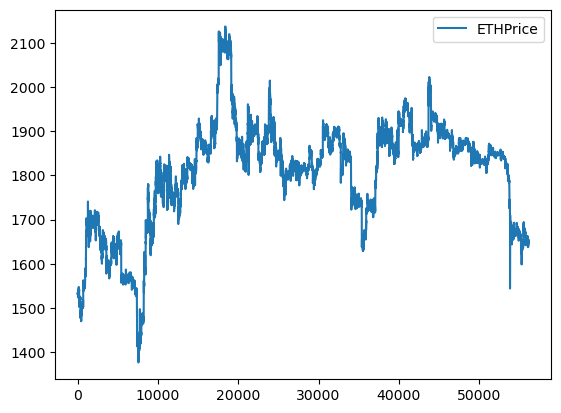

In [8]:
df.plot.line(y="ETHPrice", use_index=True)

In [9]:
df["Next"] = df["ETHPrice"].shift(-1)

In [10]:
df["Target"] = (df["Next"] > df["ETHPrice"]).astype(int)

In [11]:
target_counts = df["Target"].value_counts()
print(target_counts)


0    28505
1    27682
Name: Target, dtype: int64


In [12]:
df

,Date,ETHPrice,BTCPrice,BCHPrice,Next,Target
0,2/11/2023 23:16:46,1531.81,21810.6,124.80,1532.03,1
1,2/11/2023 23:20:46,1532.03,21812.1,124.91,1531.93,0
2,2/11/2023 23:26:46,1531.93,21810.4,124.85,1532.34,1
3,2/11/2023 23:30:46,1532.34,21810.9,124.84,1530.89,0
4,2/11/2023 23:36:46,1530.89,21804.4,124.67,1531.09,1
...,...,...,...,...,...,...
56182,8/25/2023 16:01:11,1653.18,26044.9,192.68,1652.23,0
56183,8/25/2023 16:07:11,1652.23,26029.8,192.34,1653.77,1
56184,8/25/2023 16:11:11,1653.77,26041.3,192.40,1652.86,0
56185,8/25/2023 16:17:11,1652.86,26039.5,192.19,1653.60,1


In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

train = df.iloc[:-100]
test = df.iloc[-100:]

predictors = ["ETHPrice", "BTCPrice", "BCHPrice"]
model.fit(train[predictors], train ["Target"])

RandomForestClassifier(min_samples_split=50, random_state=1)

In [14]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [15]:
preds = pd.Series(preds, index=test.index)

In [16]:
precision_score(test["Target"], preds)

0.52

In [17]:
combined = pd.concat([test["Target"], preds], axis=1)

<AxesSubplot:>

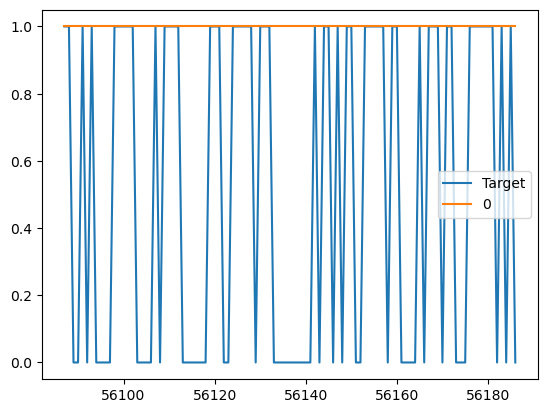

In [18]:
combined.plot()

In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv('/kaggle/input/eth5mins/Copy of Crypto Scrapping ML - Archive (1).csv', usecols=['Date', 'ETHPrice', 'BTCPrice', 'BCHPrice'])
df["Next"] = df["ETHPrice"].shift(-1)
df["Target"] = (df["Next"] > df["ETHPrice"]).astype(int)

# Add lagged features
num_lags = 3  # Number of lagged observations to include
for lag in range(1, num_lags + 1):
    for col in ["ETHPrice", "BTCPrice", "BCHPrice"]:
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)

# Drop rows with NaN resulting from lagged features
df.dropna(inplace=True)

# Train-test split
train = df.iloc[:-100]
test = df.iloc[-100:]

# Features and target variable
predictors = ["ETHPrice_lag_1", "ETHPrice_lag_2", "ETHPrice_lag_3", "BTCPrice_lag_1", "BTCPrice_lag_2", "BTCPrice_lag_3", "BCHPrice_lag_1", "BCHPrice_lag_2", "BCHPrice_lag_3"]

# Apply Min-Max scaling to features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[predictors])
test_scaled = scaler.transform(test[predictors])

# Hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 200],
    "min_samples_split": [2, 10, 20]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3)
grid_search.fit(train_scaled, train["Target"])

best_model = grid_search.best_estimator_

# Predictions on scaled test data
preds = best_model.predict(test_scaled)

# Print predictions and trading signals
for i, prediction in enumerate(preds):
    if prediction == 1:
        print(f"Predicted: Next price will go up, Buy at {test.iloc[i]['ETHPrice']}")
    else:
        print(f"Predicted: Next price will not go up, Hold at {test.iloc[i]['ETHPrice']}")

# Calculate and print precision score
precision = precision_score(test["Target"], preds)
print(f"Precision Score: {precision}")


Predicted: Next price will go up, Buy at 1638.85
Predicted: Next price will go up, Buy at 1640.92
Predicted: Next price will not go up, Hold at 1647.57
Predicted: Next price will go up, Buy at 1651.16
Predicted: Next price will go up, Buy at 1649.9
Predicted: Next price will go up, Buy at 1649.0
Predicted: Next price will go up, Buy at 1651.45
Predicted: Next price will go up, Buy at 1648.49
Predicted: Next price will go up, Buy at 1651.16
Predicted: Next price will go up, Buy at 1649.76
Predicted: Next price will go up, Buy at 1647.74
Predicted: Next price will go up, Buy at 1646.87
Predicted: Next price will go up, Buy at 1645.26
Predicted: Next price will go up, Buy at 1645.56
Predicted: Next price will go up, Buy at 1647.34
Predicted: Next price will go up, Buy at 1647.64
Predicted: Next price will go up, Buy at 1648.39
Predicted: Next price will go up, Buy at 1649.81
Predicted: Next price will go up, Buy at 1649.78
Predicted: Next price will go up, Buy at 1647.92
Predicted: Next p

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import os

# Load the dataset
data_file_path = '/kaggle/input/eth5mins/Copy of Crypto Scrapping ML - Archive (1).csv'
if os.path.exists(data_file_path):
    df = pd.read_csv(data_file_path, usecols=['Date', 'ETHPrice', 'BTCPrice', 'BCHPrice'])
else:
    print("Dataset file not found. Please check the file path.")
    exit()

# Add lagged features
num_lags = 3
for lag in range(1, num_lags + 1):
    for col in ["ETHPrice", "BTCPrice", "BCHPrice"]:
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)

# Drop rows with NaN resulting from lagged features
df.dropna(inplace=True)

# Create the "Target" column
df["Next"] = df["ETHPrice"].shift(-1)
df["Target"] = (df["Next"] > df["ETHPrice"]).astype(int)

# Train-test split
train = df.iloc[:-100]
test = df.iloc[-100:]

# Features and target variable
predictors = ["ETHPrice_lag_1", "ETHPrice_lag_2", "ETHPrice_lag_3",
              "BTCPrice_lag_1", "BTCPrice_lag_2", "BTCPrice_lag_3",
              "BCHPrice_lag_1", "BCHPrice_lag_2", "BCHPrice_lag_3"]

# Apply Min-Max scaling to features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[predictors])
test_scaled = scaler.transform(test[predictors])

# Hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 200],
    "min_samples_split": [2, 10, 20]
}

# Random Forest Classifier
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3)
grid_search_rf.fit(train_scaled, train["Target"])
best_rf_model = grid_search_rf.best_estimator_

# Gradient Boosting Classifier
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=1), param_grid, cv=3)
grid_search_gb.fit(train_scaled, train["Target"])
best_gb_model = grid_search_gb.best_estimator_

# Predictions on scaled test data using Random Forest model
preds_rf = best_rf_model.predict(test_scaled)

# Print predictions and trading signals for Random Forest model
print("Random Forest Model:")
for i, prediction in enumerate(preds_rf):
    eth_price = test.iloc[i]['ETHPrice']
    if prediction == 1:
        print(f"Predicted: Next price will go up, Buy at {eth_price}")
    else:
        print(f"Predicted: Next price will not go up, Hold at {eth_price}")

# Calculate and print precision score and classification report for Random Forest model
precision_rf = precision_score(test["Target"], preds_rf)
classification_rep_rf = classification_report(test["Target"], preds_rf)
print(f"Precision Score (Random Forest): {precision_rf}")
print("Classification Report (Random Forest):\n" + classification_rep_rf)

# Predictions on scaled test data using Gradient Boosting model
preds_gb = best_gb_model.predict(test_scaled)

# Print predictions and trading signals for Gradient Boosting model
print("Gradient Boosting Model:")
for i, prediction in enumerate(preds_gb):
    eth_price = test.iloc[i]['ETHPrice']
    if prediction == 1:
        print(f"Predicted: Next price will go up, Buy at {eth_price}")
    else:
        print(f"Predicted: Next price will not go up, Sell at {eth_price}")

# Calculate and print precision score and classification report for Gradient Boosting model
precision_gb = precision_score(test["Target"], preds_gb)
classification_rep_gb = classification_report(test["Target"], preds_gb)
print(f"Precision Score (Gradient Boosting): {precision_gb}")
print("Classification Report (Gradient Boosting):\n" + classification_rep_gb)


Random Forest Model:
Predicted: Next price will go up, Buy at 1640.92
Predicted: Next price will not go up, Hold at 1647.57
Predicted: Next price will go up, Buy at 1651.16
Predicted: Next price will go up, Buy at 1649.9
Predicted: Next price will go up, Buy at 1649.0
Predicted: Next price will go up, Buy at 1651.45
Predicted: Next price will go up, Buy at 1648.49
Predicted: Next price will go up, Buy at 1651.16
Predicted: Next price will go up, Buy at 1649.76
Predicted: Next price will go up, Buy at 1647.74
Predicted: Next price will go up, Buy at 1646.87
Predicted: Next price will go up, Buy at 1645.26
Predicted: Next price will go up, Buy at 1645.56
Predicted: Next price will go up, Buy at 1647.34
Predicted: Next price will go up, Buy at 1647.64
Predicted: Next price will go up, Buy at 1648.39
Predicted: Next price will go up, Buy at 1649.81
Predicted: Next price will go up, Buy at 1649.78
Predicted: Next price will go up, Buy at 1647.92
Predicted: Next price will go up, Buy at 1645

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: Undefine

In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# Load the most recent n data points from the CSV file
n = 500  # Adjust this value to the desired number of recent data points
df = pd.read_csv('/kaggle/input/eth5mins/Copy of Crypto Scrapping ML - Archive (1).csv', usecols=['Date', 'ETHPrice', 'BTCPrice', 'BCHPrice']).tail(n)
df["Next"] = df["ETHPrice"].shift(-1)
df["Target"] = (df["Next"] > df["ETHPrice"]).astype(int)

# Drop rows with NaN resulting from lagged features
df.dropna(inplace=True)

# Train-test split
train = df.iloc[:-1]
test = df.iloc[-1:]

# Features and target variable
predictors = ["ETHPrice", "BTCPrice", "BCHPrice"]

# Create and fit the RandomForestClassifier with default parameters
model = RandomForestClassifier(random_state=1)
model.fit(train[predictors], train["Target"])

# Predictions on test data
preds = model.predict(test[predictors])

# Print predictions and trading signals
for i, prediction in enumerate(preds):
    if prediction == 1:
        print(f"Predicted: Next price will go up, Buy at {test.iloc[i]['ETHPrice']}")
    else:
        print(f"Predicted: Next price will not go up, Sell at {test.iloc[i]['ETHPrice']}")

# Calculate and print precision score
precision = precision_score(test["Target"], preds)
print(f"Precision Score: {precision}")


Predicted: Next price will go up, Buy at 1652.86
Precision Score: 1.0
